In [1]:
!pip install keras-hub

In [2]:
#import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_hub
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2025-12-26 16:20:56.351652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766766056.569963      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766766056.622180      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766766057.078749      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766766057.078782      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766766057.078785      55 computation_placer.cc:177] computation placer alr

In [3]:
#config
BASE_PATH = "/kaggle/input/acne-grading-classificationdataset/Created Dataset"
CLASSES = ["Level_0", "Level_1", "Level_2"]
IMG_SIZE = 224
BATCH_SIZE = 16 
EPOCHS = 100
INITIAL_LR = 1e-5 

In [4]:
#data prep
filepaths, labels = [], []
for cls in CLASSES:
    folder = os.path.join(BASE_PATH, cls)
    if os.path.exists(folder):
        for f in os.listdir(folder):
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                filepaths.append(os.path.join(folder, f))
                labels.append(cls)

df = pd.DataFrame({"filename": filepaths, "class": labels})
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)

In [5]:
#focal loss/mix up
def balanced_focal_loss(gamma=2.5):
    alpha_weights = tf.constant([0.86, 0.70, 3.60], dtype=tf.float32) 
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_term = tf.math.pow(1.0 - y_pred, gamma)
        weighted_loss = alpha_weights * focal_term * cross_entropy
        return tf.math.reduce_sum(weighted_loss, axis=1)
    return loss_fn

def mixup_data_gen(generator, alpha=0.2):
    while True:
        batch = next(generator)
        X1, y1 = batch[0], batch[1]
        X2, y2 = next(generator)
        batch_size = min(X1.shape[0], X2.shape[0])
        l = np.random.beta(alpha, alpha, batch_size)
        X_l = l.reshape(batch_size, 1, 1, 1).astype('float32')
        y_l = l.reshape(batch_size, 1).astype('float32')
        X_mix = X1[:batch_size] * X_l + X2[:batch_size] * (1.0 - X_l)
        y_mix = y1[:batch_size] * y_l + y2[:batch_size] * (1.0 - y_l)
        yield (X_mix, y_mix)

In [6]:
#data loaders
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_loader = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=True
)
val_loader = val_datagen.flow_from_dataframe(
    val_df, x_col="filename", y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)
train_loader_mixup = mixup_data_gen(train_loader)

Found 799 validated image filenames belonging to 3 classes.
Found 200 validated image filenames belonging to 3 classes.


In [7]:
#model
def build_model():
    backbone = keras_hub.models.ViTBackbone.from_preset(
        "vit_base_patch16_224_imagenet21k",
        load_weights=True
    )
    
    backbone.trainable = True 
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = backbone(inputs)
    
    x = layers.Lambda(lambda x: x[:, 0, :])(x) 
    
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='gelu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='gelu')(x) # Ekstra kapasite
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss=balanced_focal_loss(),
        metrics=['accuracy']
    )
    return model

model = build_model()

I0000 00:00:1766766073.756217      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766766073.760083      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
#callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_acne_vit_model.keras', 
        monitor='val_loss', 
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=1e-7,
        verbose=1
    )
]

In [9]:
#train
history = model.fit(
    train_loader_mixup,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1766766108.081672     126 service.cc:152] XLA service 0x797e1c002540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766766108.081713     126 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766766108.081719     126 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766766113.576224     126 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766766126.425248     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.4153 - loss: 0.8268

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.43444, saving model to best_acne_vit_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4154 - loss: 0.8245 - val_accuracy: 0.5650 - val_loss: 0.4344 - learning_rate: 1.0000e-05
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.4744 - loss: 0.4406
Epoch 2: val_loss improved from 0.43444 to 0.40808, saving model to best_acne_vit_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 769ms/step - accuracy: 0.4744 - loss: 0.4408 - val_accuracy: 0.6300 - val_loss: 0.4081 - learning_rate: 1.0000e-05
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.5100 - loss: 0.4125
Epoch 3: val_loss improved from 0.40808 to 0.38730, saving model to best_acne_vit_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 791ms/step - accuracy: 0.5103 - loss: 0.4123 - val_accuracy: 0.6350 - val_loss: 0.3873 - learning_rate: 1.0000e-05
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.5163 - loss: 0.3781
Epoch 4: val_loss improv

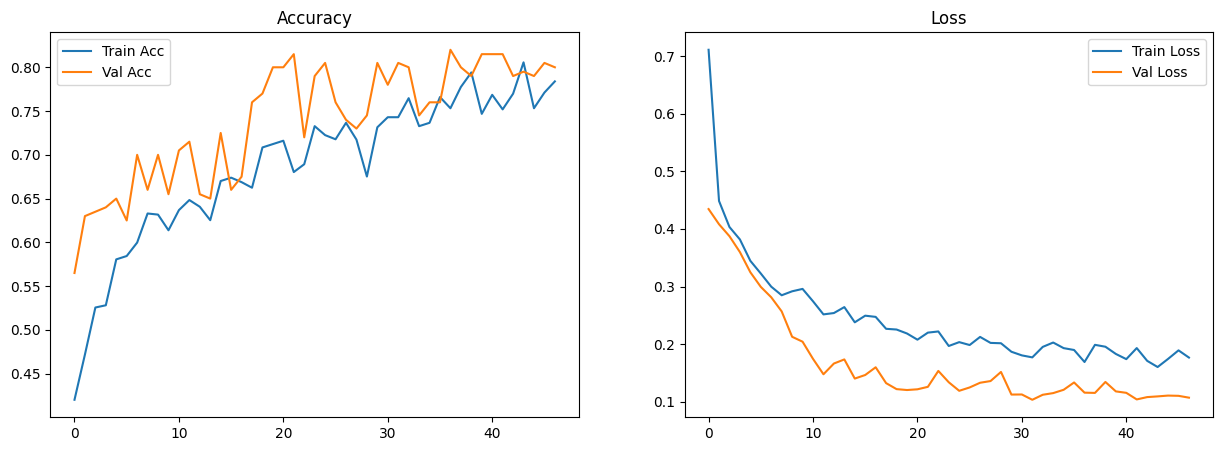

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step


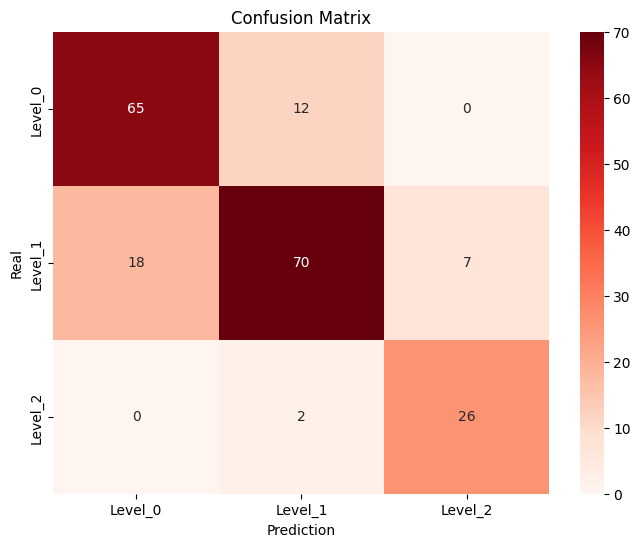

              precision    recall  f1-score   support

     Level_0       0.78      0.84      0.81        77
     Level_1       0.83      0.74      0.78        95
     Level_2       0.79      0.93      0.85        28

    accuracy                           0.81       200
   macro avg       0.80      0.84      0.82       200
weighted avg       0.81      0.81      0.80       200



In [12]:
#results
def plot_results(history, model, loader, classes):
    # Accuracy loss
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    #conf matrix
    loader.reset()
    y_true = loader.classes
    preds = model.predict(loader)
    y_pred = np.argmax(preds, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=classes))

plot_results(history, model, val_loader, CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


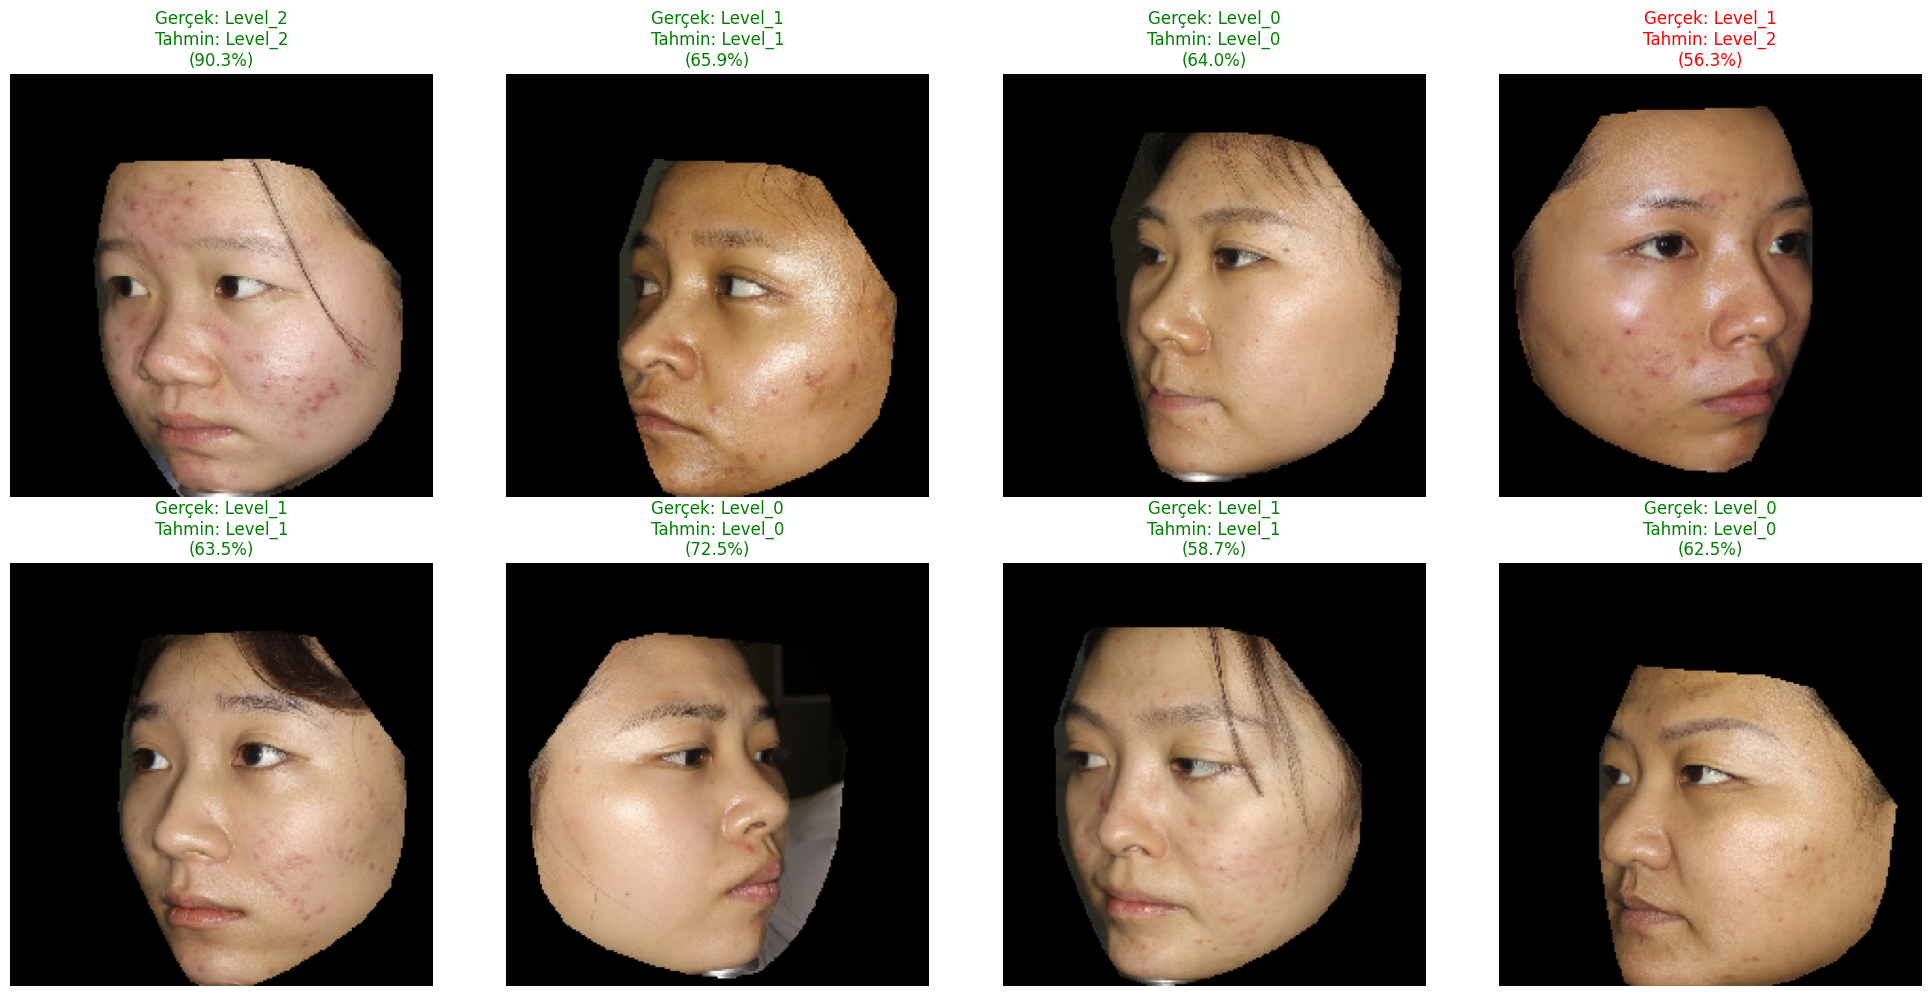

In [15]:
#predicts
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, classes, num_images=8):
    images, labels = next(loader)
    
    preds = model.predict(images)
    
    plt.figure(figsize=(20, 10))
    
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        
        plt.imshow(images[i])
        
        true_idx = np.argmax(labels[i])
        pred_idx = np.argmax(preds[i])
        confidence = preds[i][pred_idx] * 100
        
        color = 'green' if true_idx == pred_idx else 'red'
        
        plt.title(f"Gerçek: {classes[true_idx]}\nTahmin: {classes[pred_idx]}\n({confidence:.1f}%)", 
                  color=color, fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, CLASSES)